# Recommendation Systems

A recommender system is a technology that is deployed in the environment where items (products, movies, events, articles) are to be recommended to users (customers, visitors, app users, readers) or the opposite. Typically, there are many items and many users present in the environment making the problem hard and expensive to solve. Both users and items have attributes. The more you know about your users and items, the better results can be expected. A recommender system is a simple algorithm whose aim is to provide the most relevant information to a user by discovering patterns in a dataset. The most common types of recommendation systems are content based and collaborative filtering recommender systems.

# Data

Dataset for popularity based, content-based recommendation systems and hybrid recommendation systems is downloaded from https://www.kaggle.com/rounakbanik/the-movies-dataset/data#ratings_small.csv


and dataset for collaborative filtering examples is downloaded from https://grouplens.org/datasets/movielens/ 
- subsection 'recommended for education and development' (Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018)

# Types and Examples of Recommendation Systems

### Popularity based recommendation system

Popularity based recommendation system gives the same recommendation to everyone, regardless of the user's personal interest. 

In [304]:
import pandas as pd
import numpy as np
import csv
m_df = pd.read_csv('movies_metadata.csv')
m_df.head()

adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  ... release_date  \
0  Led by Woody, Andy's toys live happily in his ...  ...   1995-10-30   
1  When siblings Judy and Peter discover an encha...  ...   1995-12-15   
2  A family wedding reignites the ancient feud be...  ...   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...  ...   1995-12-22   
4  Just when George Banks has recovered from his ...  ...   1995-02-10   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0   101.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3   81452156.0   127.0           [{'iso_639_1': 'en', 'name': 'English'}]   
4   76578911.0   106.0           [{'iso_639_1': 'en', 'name': 'English'}]   

     status                                            tagline  \
0  Released                                                NaN   
1  Released          Roll the dice and unleash the excitement!   
2  Released  Still Yelling. Still Fighting. Still Ready for...   
3  Released  Friends are the people who let you be yourself...   
4  Released  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average vote_count  
0                    Toy Story  False          7.7     5415.0  
1                      Jumanji  False          6.9     2413.0  
2             Grumpier Old Men  False          6.5       92.0  
3            Waiting to Exhale  False          6.1       34.0  
4  Father of the Bride Part II  False          5.7      173.0  

[5 rows x 24 columns]

In [305]:
from ast import literal_eval
m_df['genres'] = m_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                       if isinstance(x, list) else [])

#ast.literal_eval raises an exception if the input isn't a valid Python datatype, so the code won't be executed if it's not.

IMDB's weighted rating formula.


Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,

- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report


Now, determine an cutoff value for m, the minimum votes required to be listed in the chart.

In this model used cutoff is 95th percentile that means for a movie to feature in the top N must have more votes than at least 95% of the movies in the list.


The Percentile metric - Percentiles tell you the value at which a certain percentage of your data is included. So a 95th percentile tells you the value which is greater than or equal to 95% of your data. Percentiles are very expensive to calculate. If you want to calculate the 95th percentile, sort the data set by value from highest to lowest and discard the highest 5% of the sorted samples. This works fine for small data that fits in memory.

In [306]:
#Claculation of c 
vote_counts = m_df[m_df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = m_df[m_df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [307]:
#Claculation of m
m = vote_counts.quantile(0.95)
m

434.0

In [308]:
#Extracting release year from release_date
#If ‘coerce’, then invalid parsing will be set as NaT
m_df['year'] = pd.to_datetime(m_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                           if x != np.nan else np.nan)

In [309]:
#Getting qualified movies
col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']
qualified = m_df[(m_df['vote_count'] >= m) 
                 & (m_df['vote_count'].notnull()) 
                 & (m_df['vote_average'].notnull())][col_list]

# converting vote_count and vote_average colums to integer
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [310]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [311]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)
#Sort movies based on score calculated above
qualified = qualified.sort_values('weighted_rating', ascending=False).head(50)
#Print the top 10 movies
qualified.head(10)

title  year  vote_count  \
15480                                          Inception  2010       14075   
12481                                    The Dark Knight  2008       12269   
22879                                       Interstellar  2014       11187   
2843                                          Fight Club  1999        9678   
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
292                                         Pulp Fiction  1994        8670   
314                             The Shawshank Redemption  1994        8358   
7000       The Lord of the Rings: The Return of the King  2003        8226   
351                                         Forrest Gump  1994        8147   
5814               The Lord of the Rings: The Two Towers  2002        7641   

       vote_average popularity  \
15480             8    29.1081   
12481             8    123.167   
22879             8    32.2135   
2843              8    63.8696   
4863              8    32.0707   
292               8     140.95   
314               8    51.6454   
7000              8    29.3244   
351               8    48.3072   
5814              8    29.4235   

                                                  genres  weighted_rating  
15480  [Action, Thriller, Science Fiction, Mystery, A...         7.917588  
12481                   [Drama, Action, Crime, Thriller]         7.905871  
22879                [Adventure, Drama, Science Fiction]         7.897107  
2843                                             [Drama]         7.881753  
4863                        [Adventure, Fantasy, Action]         7.871787  
292                                    [Thriller, Crime]         7.868660  
314                                       [Drama, Crime]         7.864000  
7000                        [Adventure, Fantasy, Action]         7.861927  
351                             [Comedy, Drama, Romance]         7.860656  
5814                        [Adventure, Fantasy, Action]         7.851924

## Content-Based Systems

These filtering methods are based on the description of an item and a profile of the user’s preferred choices. In a content-based recommendation system, keywords are used to describe the items; besides, a user profile is built to state the type of item this user likes. In other words, the algorithms try to recommend products which are similar to the ones that a user has liked in the past. The idea of content-based filtering is that if you like an item you will also like a ‘similar’ item. For example, when we are recommending the same kind of item like a movie or song recommendation. This approach has its roots in information retrieval and information filtering research.

Content-based system is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing interest and providing recommendations across genres.
It doesn't capture the personal intrest and biases of a user. Anyone querying on model for recommendations based on a movie will receive the same recommendations for that movie, regardless of who he is.

A major issue with content-based filtering is whether the system is able to learn user preferences from users actions about one content source and replicate them across other different content types. When the system is limited to recommending the content of the same type as the user is already using, the value from the recommendation system is significantly less when other content types from other services can be recommended. For example, recommending news articles based on browsing of news is useful, but wouldn’t it be much more useful when music, videos from different services can be recommended based on the news browsing.

## Content-Based Recommendation System Example

In [312]:
small_mdf = pd.read_csv('links_small.csv')
small_mdf = small_mdf[small_mdf['tmdbId'].notnull()]['tmdbId'].astype('int')

We need to make sure that the ID column of our main dataframe is clean and of type integer. To do this, let us try to perform  an integer conversion of our IDs and if an exception is raised, we will replace the ID with NaN. We will then proceed to drop these rows from our dataframe.

In [397]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [313]:
m_df['id'] = m_df['id'].apply(convert_int)

In [314]:
m_df[m_df['id'].isnull()]

adult  \
19730                                 - Written by Ørnås   
29503   Rune Balot goes to a casino connected to the ...   
35587   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19730              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19730  [Carousel Productions, Vision View Entertainme...   
29503  [Aniplex, GoHands, BROSTA TV, Mardock Scramble...   
35587  [Odyssey Media, Pulser Productions, Rogue Stat...   

                                                homepage  id imdb_id  \
19730  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso... NaN       0   
29503  [{'iso_3166_1': 'US', 'name': 'United States o... NaN       0   
35587           [{'iso_3166_1': 'CA', 'name': 'Canada'}] NaN       0   

      original_language                            original_title  overview  \
19730             104.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
29503              68.0      [{'iso_639_1': 'ja', 'name': '日本語'}]  Released   
35587              82.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

       ... revenue runtime spoken_languages status tagline  title  video  \
19730  ...     NaN     NaN              NaN    NaN     NaN    NaN    NaN   
29503  ...     NaN     NaN              NaN    NaN     NaN    NaN    NaN   
35587  ...     NaN     NaN              NaN    NaN     NaN    NaN    NaN   

      vote_average vote_count year  
19730          NaN        NaN  NaT  
29503          NaN        NaN  NaT  
35587          NaN        NaN  NaT  

[3 rows x 25 columns]

In [315]:
m_df = m_df.drop([19730, 29503, 35587])
m_df['id'] = m_df['id'].astype('int')

### Description Based Recommendation

In [316]:
import warnings
warnings.filterwarnings("ignore")

Making new column in dataframe with tags and overview for each movie.

In [317]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df['tagline'] = sm_df['tagline'].fillna('')
sm_df['description'] = sm_df['overview'] + sm_df['tagline']

#Replace NaN with an empty string
sm_df['description'] = sm_df['description'].fillna('')

In order to find similarity between movies, we will compute the word vectors for each movie.

We will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each movie. This will give you a matrix where each column represents a word in the vocabulary (all the words that appear in at least one document) and each column represents a movie. In its essence, the TF-IDF score is the frequency of a word occurring in a document.

Compute TF-IDF matrix

In [318]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tf.fit_transform(sm_df['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9099, 268124)

268124 different words were used to describe the 9099 movies.


With this tfidf_matrix, we can now compute a similarity score. There are several candidates for this; such as the Euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics. We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies.


Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities().

In [319]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [320]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score.

Function that takes in movie title as input and outputs most similar movies follows next steps :
- Get the index of the movie given its title.
- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
- Return the titles corresponding to the indices of the top elements.

In [321]:
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:51]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return titles.iloc[movie_indices]

In [322]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [351]:
get_recommendations('Bambi').head(10)

526     Snow White and the Seven Dwarfs
2320                         Thumbelina
3069      Thomas and the Magic Railroad
8389                      Wolf Children
848                 So Dear to My Heart
2068                     The King and I
3852                       Little Women
1714                 The Secret of NIMH
1469                  Quest for Camelot
855               The Fox and the Hound
Name: title, dtype: object

### Metadata Based Recommendation

In [324]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [325]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
m_df['id'] = m_df['id'].astype('int')
m_df.shape

(45463, 25)

In [326]:
# merging require details with our main dataframe 
m_df = m_df.merge(credits, on='id')
m_df = m_df.merge(keywords, on='id')

In [327]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9219, 28)

We now have our cast, crew, genres and credits, all in one dataframe.
From the crew, we only pick the director and from the cast we will choose the top 3 actors that appear in the credits list.

In [328]:
# Parse the stringified features into their corresponding python objects
sm_df['cast'] = sm_df['cast'].apply(literal_eval)
sm_df['crew'] = sm_df['crew'].apply(literal_eval)
sm_df['keywords'] = sm_df['keywords'].apply(literal_eval)
sm_df['cast_size'] = sm_df['cast'].apply(lambda x: len(x))
sm_df['crew_size'] = sm_df['crew'].apply(lambda x: len(x))

In [329]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [330]:
sm_df['director'] = sm_df['crew'].apply(get_director)

In [331]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
sm_df['cast'] = sm_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [332]:
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

The aim is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. We then use a Count Vectorizer to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps we follow in the preparation of genres and credits data:

- Strip Spaces and Convert to Lowercase from all our features. This way, engine will not confuse between Johnny Depp and Johnny Galecki.
- Mention Director 2 times to give it more weight relative to the entire cast

In [333]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [334]:
sm_df['director'] = sm_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
sm_df['director'] = sm_df['director'].apply(lambda x: [x,x])

We calculate the frequenct counts of every keyword that appears in the dataset.

In [335]:
s = sm_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [336]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

We do not have any use for keywords that occur only once. Therefore, these can be removed. 

In [337]:
s = s[s > 1]

In [338]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [339]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [340]:
sm_df['keywords'] = sm_df['keywords'].apply(filter_keywords)
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [341]:
sm_df['soup'] = sm_df['keywords'] + sm_df['cast'] + sm_df['director'] + sm_df['genres']
sm_df['soup'] = sm_df['soup'].apply(lambda x: ' '.join(x))

In [342]:
from sklearn.feature_extraction.text import CountVectorizer
#CountVectorizer converts a collection of text documents to a matrix of token counts.

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(sm_df['soup'])

In [343]:
# Compute the cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [344]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
#Construct a reverse map of indices and movie titles
indices = pd.Series(sm_df.index, index=sm_df['title'])

In [345]:
get_recommendations('The Dark Knight').head(10)

8031                 The Dark Knight Rises
6218                         Batman Begins
7659            Batman: Under the Red Hood
6623                          The Prestige
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
2085                             Following
9024    Batman v Superman: Dawn of Justice
Name: title, dtype: object

### Grouping tags with Non-Negative Matrix Factorization

In [384]:
sm_df['tagline'].fillna('').head()

0                                                     
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: tagline, dtype: object

In [354]:
from sklearn.decomposition import NMF

In [356]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, stop_words='english')
X = vectorizer.fit_transform(sm_df['tagline'].fillna(''))
idx_to_word = np.array(vectorizer.get_feature_names())
nmf = NMF(n_components=10, solver="mu") 
W = nmf.fit_transform(X) 
H = nmf.components_ 

In [357]:
for i, topic in enumerate(H):
     print("Group of tags {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Group of tags 1: fall,power,forget,know,woman,wall,forever,sex,hope,love
Group of tags 2: party,earth,ready,isn,way,woman,change,comes,death,life
Group of tags 3: job,lives,dangerous,loved,men,make,war,women,woman,man
Group of tags 4: soul,unexpected,family,musical,way,dark,year,heart,romantic,comedy
Group of tags 5: good,screen,little,america,real,great,adventure,greatest,come,time
Group of tags 6: real,little,begins,greatest,american,told,extraordinary,based,true,story
Group of tags 7: change,welcome,picture,men,end,save,saving,changed,war,world
Group of tags 8: little,men,dream,heart,die,thought,doesn,got,beginning,just
Group of tags 9: high,lifetime,movie,family,greatest,york,terror,evil,adventure,new
Group of tags 10: got,movie,ve,way,know,murder,family,like,don,ll


## Collaborative Filterting

This filtering method is usually based on collecting and analyzing information on user’s behaviors, their activities or preferences and predicting what they will like based on the similarity with other users. A key advantage of the collaborative filtering approach is that it does not rely on machine analyzable content and thus it is capable of accurately recommending complex items such as movies without requiring an “understanding” of the item itself. Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. A simple example would be recommending a movie to a user based on the fact that their friend liked the movie. There are two types of collaborative models Memory-based methods and Model-based methods. 

The advantage of memory-based techniques is that they are simple to implement and the resulting recommendations are often easy to explain. They are divided into two:

- User-based (User-User) collaborative filtering

In this model products are recommended to a user based on the fact that the products have been liked by users similar to the user. This algorithm is very effective but takes a lot of time and resources. This type of filtering requires computing every customer pair information which takes time. So, for big base platforms, this algorithm is hard to put in place.


- Item-based (Item-Item) collaborative filtering

It is very similar to the previous algorithm, but instead of finding a customer look alike, we try finding item look alike. Once we have item look alike matrix, we can easily recommend alike items to a customer who has purchased any item from the store. This algorithm requires far fewer resources than user-user collaborative filtering. Hence, for a new customer, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between customers. These systems identify similar items based on users’ previous ratings.

Model-based methods are based on matrix factorization and they are better at dealing with sparsity. They are developed using data mining, machine learning algorithms to predict user's rating of unrated items. In this approach techniques such as dimensionality reduction are used to improve the accuracy. Examples of such model-based methods include decision trees, rule-based models, Bayesian methods and latent factor models.

## Collaborative Filtering Recommendation System Example

In [154]:
import numpy as np  
import pandas as pd

ratings_data = pd.read_csv("ratings.csv")  
ratings_data.head()  

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

There is one problem with ratings dataset. It contains the IDs of the movies but not their titles. We'll need movie names for the movies we're recommending. The movie names are stored in the "movies.csv" file.

In [155]:
movie_names = pd.read_csv("movies.csv")  
movie_names.head()  

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

As we can see, this dataset contains movieId, the title of the movie, and its genre. We need a dataset that contains the userId, movie title, and its ratings. We have this information in two different dataframe objects: "ratings_data" and "movie_names". To get our desired information in a single dataframe, we can merge the two dataframes objects on the movieId column since it is common between the two dataframes.

In [156]:
movie_data = pd.merge(ratings_data, movie_names, on='movieId') 
movie_data.head() 

userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy

Now let's take a look at the average rating of each movie. To do so, we can group the dataset by the title of the movie and then calculate the mean of the rating for each movie. 

In [157]:
movie_data.groupby('title')['rating'].mean().head()  

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

Sort the ratings in the descending order of their average ratings:

In [158]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()  

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

The movies have now been sorted according to the ascending order of their ratings. However, there is a problem. A movie can make it to the top of the above list even if only a single user has given it five stars. Therefore, the above stats can be misleading. Normally, a movie which is really a good one gets a higher rating by a large number of users.

In [159]:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()  

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

Now really good movies are at the top. The above list supports our point that good movies normally receive higher ratings. Now we know that both the average rating per movie and the number of ratings per movie are important attributes. Let's create a new dataframe that contains both of these attributes.

In [160]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())  

In [161]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [162]:
ratings_mean_count.head()  

rating  rating_counts
title                                                         
'71 (2014)                                  4.0              1
'Hellboy': The Seeds of Creation (2004)     4.0              1
'Round Midnight (1986)                      3.5              2
'Salem's Lot (2004)                         5.0              1
'Til There Was You (1997)                   4.0              2

Histogram of rating counts

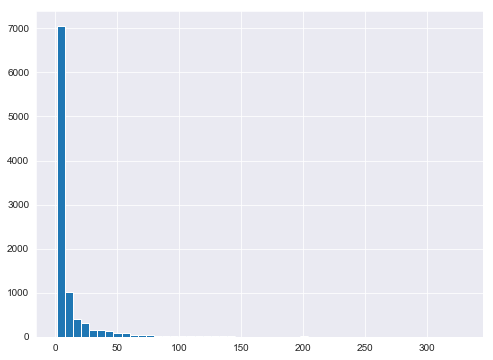

In [163]:
import matplotlib.pyplot as plt  
import seaborn as sb  
sb.set_style('dark')  
%matplotlib inline

plt.figure(figsize=(8,6))  
ratings_mean_count['rating_counts'].hist(bins=50)  

From the output, you can see that most of the movies have received less than 50 ratings. While the number of movies having more than 100 ratings is very low. On the following plot is histogram of average ratings.

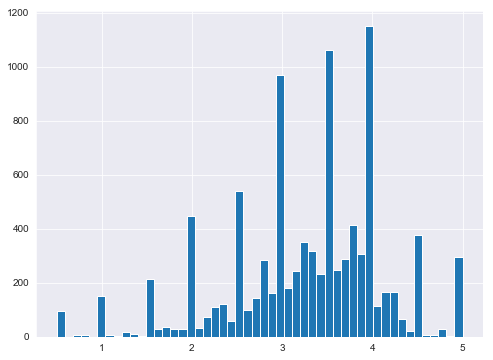

In [164]:
plt.figure(figsize=(8,6)) 
ratings_mean_count['rating'].hist(bins=50) 

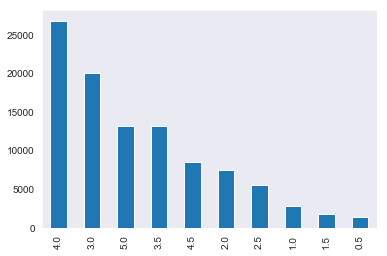

In [387]:
movie_data.rating.value_counts().plot(kind='bar')
plt.show()

Average ratings against the number of ratings is on the following plot.

<Figure size 576x432 with 0 Axes>

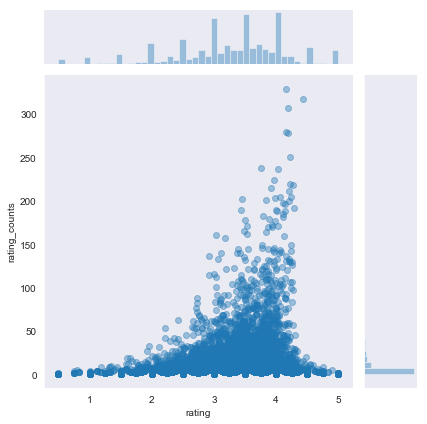

In [166]:
plt.figure(figsize=(8,6))   
sb.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4) 

The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

### Finding Similarities Between Movies based on ratings

We will use the correlation between the ratings of a movie as the similarity metric. To find the correlation between the ratings of the movie, we need to create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie. 

In [126]:
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()  

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   
5                             NaN                              NaN   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      NaN                   NaN                          NaN   
2                      NaN                   NaN                          NaN   
3                      NaN                   NaN                          NaN   
4                      NaN                   NaN                          NaN   
5                      NaN                   NaN                          NaN   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  NaN  ...          NaN           NaN   
2                                  NaN  ...          NaN           NaN   
3                                  NaN  ...          NaN           NaN   
4                                  NaN  ...          NaN           NaN   
5                                  NaN  ...          NaN           NaN   

title   [REC]² (2009)  [REC]³ 3 Génesis (2012)  \
userId                                           
1                 NaN                      NaN   
2                 NaN                      NaN   
3                 NaN                      NaN   
4                 NaN                      NaN   
5                 NaN                      NaN   

title   anohana: The Flower We Saw That Day - The Movie (2013)  \
userId                                                           
1                                                     NaN        
2                                                     NaN        
3                                                     NaN        
4                                                     NaN        
5                                                     NaN        

title   eXistenZ (1999)  xXx (2002)  xXx: State of the Union (2005)  \
userId                                                                
1                   NaN         NaN                             NaN   
2                   NaN         NaN                             NaN   
3                   NaN         NaN                             NaN   
4                   NaN         NaN                             NaN   
5                   NaN         NaN                             NaN   

title   ¡Three Amigos! (1986)  À nous la liberté (Freedom for Us) (1931)  
userId                                                                    
1                         4.0                                        NaN  
2                         NaN                            

In [127]:
pulp_fiction_ratings = user_movie_rating['Pulp Fiction (1994)'] 

In [128]:
pulp_fiction_ratings.head()

userId
1    3.0
2    NaN
3    NaN
4    1.0
5    5.0
Name: Pulp Fiction (1994), dtype: float64

In [129]:
movies_like_pulp_fiction = user_movie_rating.corrwith(pulp_fiction_ratings)

corr_pulp_fiction = pd.DataFrame(movies_like_pulp_fiction, columns=['Correlation'])  
corr_pulp_fiction.dropna(inplace=True)  
corr_pulp_fiction.head()  

C:\workspace\anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\workspace\anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Correlation
title                                      
'burbs, The (1989)                -0.187323
(500) Days of Summer (2009)       -0.044034
*batteries not included (1987)    -0.738549
...And Justice for All (1979)     -0.188982
10 Cent Pistol (2015)              1.000000

In [130]:
corr_pulp_fiction.sort_values('Correlation', ascending=False).head(10)  

Correlation
title                                           
Underground (1995)                           1.0
Misérables, Les (2000)                       1.0
Klute (1971)                                 1.0
Eddie the Eagle (2016)                       1.0
Wings of the Dove, The (1997)                1.0
After Life (Wandafuru raifu) (1998)          1.0
Thieves (Voleurs, Les) (1996)                1.0
First Snow (2006)                            1.0
In-Laws, The (2003)                          1.0
Trip to Bountiful, The (1985)                1.0

From the output you can see that the movies that have high correlation with "Pulp Fiction (1994)" are not very well known. This shows that correlation alone is not a good metric for similarity because there can be a user who watched '"Pulp Fiction (1994)" and only one other movie and rated both of them as 5.

A solution to this problem is to retrieve only those correlated movies that have at least more than 50 ratings. To do so, will add the rating_counts column from the rating_mean_count dataframe to our corr_pulp_fiction dataframe. 

In [131]:
corr_pulp_fiction = corr_pulp_fiction.join(ratings_mean_count['rating_counts'])  
corr_pulp_fiction.head()

Correlation  rating_counts
title                                                     
'burbs, The (1989)                -0.187323             17
(500) Days of Summer (2009)       -0.044034             42
*batteries not included (1987)    -0.738549              7
...And Justice for All (1979)     -0.188982              3
10 Cent Pistol (2015)              1.000000              2

5 most similar movies 

In [133]:
corr_pulp_fiction [corr_pulp_fiction ['rating_counts']>50].sort_values('Correlation', ascending=False)[1:].head() 
#first movie is "Pulp Fiction" because correlation is equal to 1, so we skip first movie

Correlation  rating_counts
title                                                      
Wolf of Wall Street, The (2013)     0.579915             54
Fight Club (1999)                   0.543465            218
Kill Bill: Vol. 1 (2003)            0.504147            131
Interstellar (2014)                 0.503411             73
True Romance (1993)                 0.484209             65

## Matrix Factorization Recommendation System Example

Matrix factorization is the breaking down of one matrix into a product of multiple matrices. There are many different ways to factor matrices, but singular value decomposition is particularly useful for making recommendations. 

In [95]:
ratings_df = pd.read_csv("ratings.csv")
movies_df = pd.read_csv("movies.csv")

Setting the format of ratings matrix to be one row per user and one column per movie.

In [97]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R_df.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  193583  193585  193587  193609  
userId                                   
1           0.0     0.0     0.0     0.0  
2           0.0     0.0     0.0     0.0  
3           0.0     0.0     0.0     0.0  
4           0.0     0.0     0.0     0.0  
5           0.0     0.0     0.0     0.0  

[5 rows x 9724 columns]

Last step with setting up data is to de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [396]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

## Singular Value Decomposition (SVD)

SVD in the context of recommendation systems is used as a collaborative filtering (CF) algorithm. Most CF algorithms are based on user-item rating matrix where each row represents a user, each column an item. The entries of this matrix are ratings given by users to items. SVD is a matrix factorization technique that is usually used to reduce the number of features of a data set by reducing space dimensions from N to K where K < N. For the purpose of the recommendation systems however, we are only interested in the matrix factorization part keeping same dimensionality. The matrix factorization is done on the user-item ratings matrix. From a high level, matrix factorization can be thought of as finding 2 matrices whose product is the original matrix.

In [99]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [100]:
sigma = np.diag(sigma)

In [101]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)

With the predictions matrix for every user, we can build a function to recommend movies for any user. All we need to do is return the movies with the highest predicted rating that the specified user hasn’t already rated. Though we didn’t actually use any explicit movie content features (such as genre or title), we’ll merge in that information to get a more complete picture of the recommendations.

In [108]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

already_rated, predictions = recommend_movies(preds_df, 137, movies_df, ratings_df, 10)

User 137 has already rated 141 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [109]:
already_rated.head(10)

userId  movieId  rating   timestamp  \
34      137      951     5.0  1204859789   
55      137     1221     5.0  1204859699   
31      137      923     5.0  1204859839   
30      137      922     5.0  1204859734   
29      137      919     5.0  1204859924   
27      137      912     5.0  1204859738   
127     137     6650     5.0  1204863597   
54      137     1219     5.0  1204859799   
49      137     1204     5.0  1204859766   
22      137      858     5.0  1204859691   

                                             title  \
34                          His Girl Friday (1940)   
55                  Godfather: Part II, The (1974)   
31                             Citizen Kane (1941)   
30   Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
29                        Wizard of Oz, The (1939)   
27                               Casablanca (1942)   
127                Kind Hearts and Coronets (1949)   
54                                   Psycho (1960)   
49                       Lawrence of Arabia (1962)   
22                           Godfather, The (1972)   

                                 genres  
34                       Comedy|Romance  
55                          Crime|Drama  
31                        Drama|Mystery  
30              Drama|Film-Noir|Romance  
29   Adventure|Children|Fantasy|Musical  
27                        Drama|Romance  
127                        Comedy|Drama  
54                         Crime|Horror  
49                  Adventure|Drama|War  
22                          Crime|Drama

In [110]:
predictions

movieId                                              title  \
901      1276                              Cool Hand Luke (1967)   
2048     2858                             American Beauty (1999)   
861      1213                                  Goodfellas (1990)   
987      1387                                        Jaws (1975)   
1137     1617                           L.A. Confidential (1997)   
1408     2019        Seven Samurai (Shichinin no samurai) (1954)   
877      1240                             Terminator, The (1984)   
855      1201  Good, the Bad and the Ugly, The (Buono, il bru...   
912      1287                                     Ben-Hur (1959)   
787      1089                              Reservoir Dogs (1992)   

                                genres  
901                              Drama  
2048                     Drama|Romance  
861                        Crime|Drama  
987                      Action|Horror  
1137  Crime|Film-Noir|Mystery|Thriller  
1408            Action|Adventure|Drama  
877             Action|Sci-Fi|Thriller  
855           Action|Adventure|Western  
912             Action|Adventure|Drama  
787             Crime|Mystery|Thriller

## SVD with Surprise library

Surprise is a Python scikit building and analyzing recommender systems.

Surprise was designed with the following purposes in mind:

- Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
- Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
- Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, NMF), and many others. Also, various similarity measures (cosine, pearson…) are built-in.
- Provide tools to evaluate, analyse and compare the algorithms performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

In this example we will use algorithm Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give recommendations.

In [291]:
from surprise import Reader, Dataset, SVD, evaluate

In [388]:
reader = Reader()

In [389]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

To load a dataset from a pandas dataframe, you will need the load_from_df() method. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order.

In [390]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [391]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8707
MAE:  0.6700
------------
Fold 2
RMSE: 0.8652
MAE:  0.6665
------------
Fold 3
RMSE: 0.8775
MAE:  0.6747
------------
Fold 4
RMSE: 0.8843
MAE:  0.6756
------------
Fold 5
RMSE: 0.8776
MAE:  0.6748
------------
------------
Mean RMSE: 0.8751
Mean MAE : 0.6723
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.870710487610586,
                             0.8651587497076398,
                             0.8774578253083198,
                             0.8843320607882494,
                             0.8776113208292874],
                            'mae': [0.6700073206621925,
                             0.6664722455598445,
                             0.6747122112256412,
                             0.6756235976286039,
                             0.6748237980332907]})

In [392]:
from surprise.model_selection import train_test_split

#Splitting dataset in train and test set in a ratio of 75%:25%
trainset, testset = train_test_split(data, test_size=0.25)
svd.train(trainset)

In [395]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.9971982011874916, details={'was_impossible': False})

In [ ]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [296]:
ratings[ratings['userId'] == 1].head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [295]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=4.174803894609439, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 4.1748. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## k-Nearest Neighbors (kNN) algorithm with Surprise library

K-Nearest Neighbours is one of the most basic classification algorithms in Machine Learning. 

As we would need to in any machine learning problem, we must first find a way to represent data points as feature vectors. A feature vector is our mathematical representation of data, and since the desired characteristics of our data may not be inherently numerical, preprocessing and feature-engineering may be required in order to create these vectors. Given data with N unique features, the feature vector would be a vector of length N, where entry I of the vector represents that data point’s value for feature I.

Unlike most other methods of classification, kNN falls under lazy learning, which means that there is no explicit training phase before classification. Instead, any attempts to generalize or abstract the data is made upon classification. While this does mean that we can immediately begin classifying once we have our data, there are some inherent problems with this type of algorithm. We must be able to keep the entire training set in memory unless we apply some type of reduction to the data-set, and performing classifications can be computationally expensive as the algorithm parse through all data points for each classification. For these reasons, kNN tends to work best on smaller data-sets that do not have many features.


Once we have formed our training data-set, which is represented as an M x N matrix where M is the number of data points and N is the number of features, we can now begin classifying. The aim of the kNN method is, for each classification query, to:
1. Compute a distance value between the item to be classified and every item in the training data-set
2. Pick the k closest data points (the items with the k lowest distances)
3. Conduct a “majority vote” among those data points — the dominating classification in that pool is decided as the final classification


In [368]:
from surprise import KNNBasic

In [363]:
df_new = pd.read_csv("ratings.csv")

In [364]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']], reader)

In [370]:
kNN = KNNBasic()
evaluate(kNN, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9526
MAE:  0.7296
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9498
MAE:  0.7269
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9374
MAE:  0.7164
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9555
MAE:  0.7316
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9513
MAE:  0.7302
------------
------------
Mean RMSE: 0.9493
Mean MAE : 0.7270
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.952588739820993,
                             0.9498095077988535,
                             0.9374148088927511,
                             0.9555231559447462,
                             0.9513463820222556],
                            'mae': [0.7296320978002896,
                             0.7269156377906747,
                             0.7163822011100671,
                             0.7316387812244424,
                             0.7301909775021421]})

In [371]:
trainset = data.build_full_trainset()
kNN.train(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [372]:
ratings[ratings['userId'] == 1].head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [373]:
kNN.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.134330090485319, details={'actual_k': 5, 'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 3.134. Like in previous examples with suprise library algorithm works on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Non-Negative Matrix Factorization with Surprise library

A collaborative filtering algorithm based on Non-negative Matrix Factorization.
This algorithm is very similar to SVD. User and item factors are kept positive. 
The optimization procedure is a stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

Parameters:	
- n_factors – The number of factors. Default is 15.
- n_epochs – The number of iteration of the SGD procedure. Default is 50.
- biased (bool) – Whether to use baselines (or biases). Default is False.
- reg_pu – The regularization term for users λu. Default is 0.06.
- reg_qi – The regularization term for items λi. Default is 0.06.
- reg_bu – The regularization term for bu. Only relevant for biased version. Default is 0.02.
- reg_bi – The regularization term for bi. Only relevant for biased version. Default is 0.02.
- lr_bu – The learning rate for bu. Only relevant for biased version. Default is 0.005.
- lr_bi – The learning rate for bi. Only relevant for biased version. Default is 0.005.
- init_low – Lower bound for random initialization of factors. Must be greater than 0 to ensure non-negative factors. Default is 0.
- init_high – Higher bound for random initialization of factors. Default is 1.
- random_state (int, RandomState instance from numpy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. Default is None.
- verbose – If True, prints the current epoch. Default is False.

In [374]:
from surprise import NMF

In [375]:
df_new = pd.read_csv("ratings.csv")

In [376]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']], reader)

In [377]:
NMF = NMF()
evaluate(NMF, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 0.9463
MAE:  0.7362
------------
Fold 2
RMSE: 0.9631
MAE:  0.7478
------------
Fold 3
RMSE: 0.9505
MAE:  0.7384
------------
Fold 4
RMSE: 0.9463
MAE:  0.7410
------------
Fold 5
RMSE: 0.9493
MAE:  0.7405
------------
------------
Mean RMSE: 0.9511
Mean MAE : 0.7408
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9463396017870186,
                             0.9630582609248578,
                             0.9505020692894955,
                             0.9462684770838408,
                             0.9492741244506111],
                            'mae': [0.7361682207347692,
                             0.7478415988312338,
                             0.738365294190813,
                             0.741032227945049,
                             0.7405163030885903]})

In [378]:
trainset = data.build_full_trainset()
NMF.train(trainset)

In [379]:
ratings[ratings['userId'] == 1].head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [380]:
NMF.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.5693718164171306, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 3.569.

## Neural Collaborative Filtering Example

The fastai library simplifies training fast and accurate neural nets using modern best practices. It's based on research in to deep learning best practices undertaken at fast.ai, including "out of the box" support for vision, text, tabular, and collab (collaborative filtering) models.

In [79]:
import fastai
from fastai.collab import CollabDataBunch, collab_learner

Read the data from the csv file into a Pandas dataframe, and create a FastAI data bunch which:

- Converts the Pandas data frame into tensors

A tensor is a generalization of vectors and matrices and is easily understood as a multidimensional array. We can calculate arithmetic operations with tensors. A vector is a one-dimensional or first order tensor and a matrix is a two-dimensional or second order tensor. As a tool, tensors and tensor algebra is widely used in the fields of physics and engineering. It is a term and set of techniques known in machine learning in the training and operation of deep learning models can be described in terms of tensors.

- It splits the data into a training set and a validation set
- Creates data loaders to access the data in batches

In the neural network terminology:

- one epoch = one forward pass and one backward pass of all the training examples
- batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- number of iterations = number of passes, each pass using (batch size) number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).


Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

- Checks if a GPU is available, and moves the data to the GPU

In [81]:
ratings_data = pd.read_csv("ratings.csv")
ratings_data.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [82]:
data = CollabDataBunch.from_df(ratings_data, valid_pct=0.1) #splits data in 90% trainig and 10% test
data.show_batch()

Idea of model is to represent each user u and each movie m by vector of a predefined length n. The rating for the movie m by the user u, as predicted by the model is simply the dot product of the two vectors.

Since the vectors are chosen randomly, it’s quite unlikely that the ratings predicted by the model match the actual ratings. Our objective, while training the model, is to gradually adjust the elements inside the user & movie vectors so that predicted ratings get closer to the actual ratings.

We can use the collab_learner method from fastai to create a neural collaborative filtering model. 
It creates a simple model with Embedding weights and biases for n_users and n_items. (Apart from the vectors for users and movies, it also add bias terms to account for outliers, since some users tend to always rate movies very high or very low, and some movies tend to be universally acclaimed or disliked.) Takes the dot product of the embeddings and adds the bias, then if y_range is specified, feed the result to a sigmoid rescaled to go from y_range[0] to y_range[1].

In [83]:
learn = collab_learner(data, n_factors=40, y_range=[0, 5.5], wd=.1) 

It applies the Sigmoid activation function to the above output, and scales it so that the result always lies in the given y_range, which is 0 to 5.5 in this case.

In artificial neural networks, the activation function of a node defines the output of that node given an input or set of inputs.

A sigmoid function is a mathematical function having a characteristic “S”-shaped curve or sigmoid curve. Often, sigmoid function refers to the special case of the logistic function which generate a set of probability outputs between 0 and 1 when fed with a set of inputs. Therefore, it is especially used for models where we have to predict the probability as an output.

### Training the model

The learner uses the mean squared error loss function to evaluate the predictions of the model, and the Adam optimizer to adjust the parameters (vectors and biases) using gradient descent. Before we train the model, we use the learning rate finder to select a good learning for the optimizer.

Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


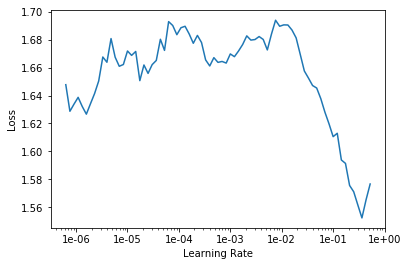

In [84]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

We can see that the decrease in loss starts to decrease when the learning rate is around 0.01. We can choose this as our learning rate and train for 5 epochs, while annealing the learning rate using the 1-cycle policy, which leads to faster convergence.

If the learning rate (LR) is too small, overfitting can occur. Large learning rates help to regularize
the training but if the learning rate is too large, the training will diverge. Hence a grid search of short
runs to find learning rates that converge or diverge is possible but there is an easier way.


Cyclical learning rates (CLR) and the learning rate range test were proposed as a recipe for choosing the learning rate.
To use CLR, one specifies minimum and maximum learning rate boundaries and a stepsize. The
stepsize is the number of iterations (or epochs) used for each step and a cycle consists of two such
steps – one in which the learning rate linearly increases from the minimum to the maximum and
the other in which it linearly decreases.


Learning rate policy “1 cycle”  allows the accuracy to plateau before the training ends - use one cycle that is smaller than the total number of iterations/epochs and allow the learning rate to decrease several orders of magnitude less than the initial learning rate for the remaining iterations.

In [85]:
learn.fit_one_cycle(5, 0.01)

In [86]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users,items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[:16]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))

Real	Pred	Difference
3.0	3.4	0.4
4.0	4.1	0.1
2.0	3.5	1.5
2.0	3.3	1.3
4.5	4.0	-0.5
4.0	4.0	-0.0
3.5	4.0	0.5
5.0	3.0	-2.0
2.0	3.6	1.6
3.0	4.0	1.0
3.0	3.3	0.3
4.0	4.1	0.1
3.0	3.2	0.2
3.5	3.7	0.2
1.0	2.7	1.7
4.0	4.0	0.0


From previous results we can see that the predictions are quite close to the actual ratings.

## Hybrid Recommendation Systems

Combining collaborative and content-based recommendation can be more effective. Hybrid approaches can be implemented by making content-based and collaborative-based predictions separately and then combining them. Further, by adding content-based capabilities to a collaborative-based approach and vice versa; or by unifying the approaches into one model.

Hybrid methods can provide more accurate recommendations than pure approaches. Such methods can be used to overcome the common problems in recommendation systems such as cold start and the data paucity problem.

Netflix is a good example of the use of hybrid recommender systems. The website makes recommendations by comparing the watching and searching habits of similar users (i.e., collaborative filtering) as well as by offering movies that share characteristics with films that a user has rated highly (content-based filtering).

In [275]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(sm_df[['title', 'id']], on='id').set_index('title')

In [276]:
indices_map = id_map.set_index('id')

In [279]:
def hybrid(userId, title):
    
    #Extract cosine similarity index of the movie
    idx = indices[title]
    
    #Extract the TMDB id of the movie
    tmdbId = id_map.loc[title]['id']
    
    #Extract the movie ID 
    movie_id = id_map.loc[title]['movieId']
    
    #Extract the similarity scores and their corresponding index for every movie fromm the cosine_sim matrix
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    
    #Sort the (index, score) tuples in decreasing order of similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #Select the top 10 movies, excluding the first
    sim_scores = sim_scores[1:10]
    
    #Store the cosine_sim indices of the top 1 movies in a list
    movie_indices = [i[0] for i in sim_scores]
    
    #Extract the movie features
    movies = sm_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [280]:
hybrid(1, 'Avatar')

title  vote_count  vote_average  year     id  \
8401          Star Trek Into Darkness      4479.0           7.4  2013  54138   
974                            Aliens      3282.0           7.7  1986    679   
522        Terminator 2: Judgment Day      4274.0           7.7  1991    280   
4966             Hercules in New York        63.0           3.7  1969   5227   
4017                  Hawk the Slayer        13.0           4.5  1980  25628   
3060  Sinbad and the Eye of the Tiger        39.0           6.3  1977  11940   
1668       Return from Witch Mountain        38.0           5.6  1978  14822   
8724                Jupiter Ascending      2816.0           5.2  2015  76757   
3216               Dungeons & Dragons       159.0           3.9  2000  11849   

           est  
8401  4.612401  
974   4.447515  
522   4.324874  
4966  4.188931  
4017  4.188931  
3060  4.159020  
1668  4.031334  
8724  3.873385  
3216  3.350090

In [281]:
hybrid(20, 'Avatar')

title  vote_count  vote_average  year     id  \
522        Terminator 2: Judgment Day      4274.0           7.7  1991    280   
974                            Aliens      3282.0           7.7  1986    679   
8401          Star Trek Into Darkness      4479.0           7.4  2013  54138   
4966             Hercules in New York        63.0           3.7  1969   5227   
4017                  Hawk the Slayer        13.0           4.5  1980  25628   
1668       Return from Witch Mountain        38.0           5.6  1978  14822   
3060  Sinbad and the Eye of the Tiger        39.0           6.3  1977  11940   
8724                Jupiter Ascending      2816.0           5.2  2015  76757   
3216               Dungeons & Dragons       159.0           3.9  2000  11849   

           est  
522   4.044079  
974   3.755713  
8401  3.704553  
4966  3.564460  
4017  3.564460  
1668  3.403138  
3060  3.271356  
8724  3.023482  
3216  2.532175

For hybrid recommendendation system, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Problems with Recommendation Systems

- Cold start


Sometimes interactions are missing. Cold start products or cold start users do not have enough interactions for reliable measurement of their interaction similarity so collaborative filtering methods fail to generate recommendations. Cold start problem can be reduced when attribute similarity is taken into account.


Solution: Use content-boosted filtering approach. It is combination of content-based filtering and collaborative filtering. We can use product description and attributes as well as user demographic to recommend products to users.


- Data sparsity


User-item rating matrix is very sparse( many null items ) because stores have many products and all those products will not be rated by many users. Actually very few people rate products.


Solution: Use dimensionality reduction. Remove unnecessary users and products from where we are not learning much and reduce sparsity of user-item rating matrix.



- Grey-Sheep Problem


From the name grey sheep we understand his behavior are unpredictable.


Solution: Pure collaborative filtering does not work. So use content-boosted filtering like in cold start problem.



- Synonymy


Products that are practically same but different. For example, different editions of a book or pdf or physical copy of book. Since we don’t use product description for collaborative filtering we can miss the information about synonymy. Since online stores have different codes for these items, finding synonymy can be problem.


Solution: Latent collaborative filtering is the type of algorithm that can identify hidden factors from the data. This algorithm works really well for synonymy as well. So if we have lot of items with synonymy this is the way to go.


- Shilling Attacks


People who are trying to game the recommendation system. For example our system has a weird author who gave ton of ratings for his books and tons of negative ratings for other people’s book.


Solution: Take precautions and monitor user behavior.